In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#--export--#
from exports.e_11_MoreStats import *

# General ReLU Class
In our previous notebook, we noticed that the majority of our activations are accumulating around some minimum value. What we really want is for the neurons to be exploiting the full richness of the activation space. We tried Kaiming initialization, which did some help, but let's go further and try to modify our ReLUs. We'll do this by defining a general relu class

In [3]:
#--export--#
class GReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
def cnn_layers_GReLU(data_w, n_kernels, **kwargs):
    n_kernels = [1] + n_kernels
    
    return [
        conv_GReLU(n_kernels[i], n_kernels[i+1], 5 if i==0 else 3, **kwargs)
        for i in range(len(n_kernels)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_kernels[-1], data_w.n_out)]

def conv_GReLU(n_inp, n_out, kernel_size=3, stride=2, **kwargs):
    return nn.Sequential(
            nn.Conv2d(n_inp, n_out,
                      kernel_size,
                      padding=kernel_size//2,
                      stride=stride),
            GReLU(**kwargs))

In [ ]:
GReLU_params = {'leak': 0.1, 'sub': 0.4, 'maxv': 6.}

kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers_GReLU(data_w, kernel_ns, **GReLU_params))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [5]:
#--export--#
def append_stats_hist_GReLU(hook, model, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(out.data.mean().cpu())
    stds .append(out.data.std().cpu())
    hists.append(out.data.cpu().histc(bins=40, min=-3, max=7)) # a histogram telling us how many activations in each bin

In [6]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(1, model_w)

train: [0.724211015625]
valid: [0.3074953369140625]


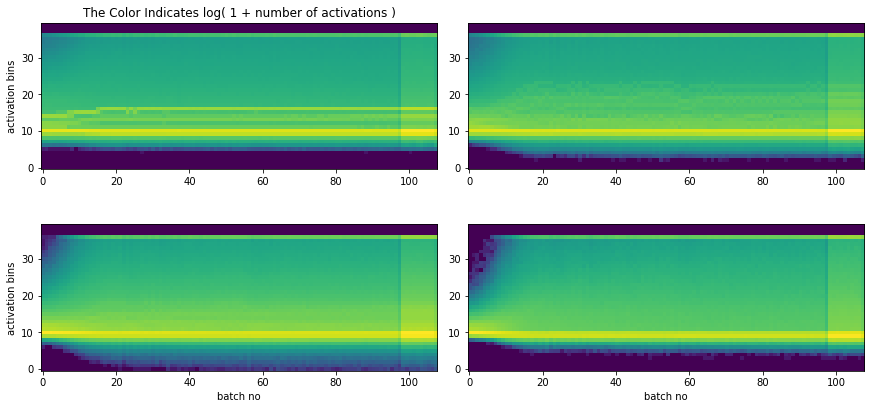

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
plt.tight_layout()
axes[0,0].set_title('The Color Indicates log( 1 + number of activations )')
for ax in axes[1]: ax.set_xlabel('batch no')
for ax in axes[:,0]: ax.set_ylabel('activation bins')

Wow, this already looks a lot better! But are our activations still accumulating around 0?

In [9]:
def get_max_min_hist(h, mn=True):
    h1 = torch.stack(h.stats[2]).t().float()
    return (h1[9:11] if mn else h1[-2:]).sum(0)/h1.sum(0) # bins 19-11 lie around 0

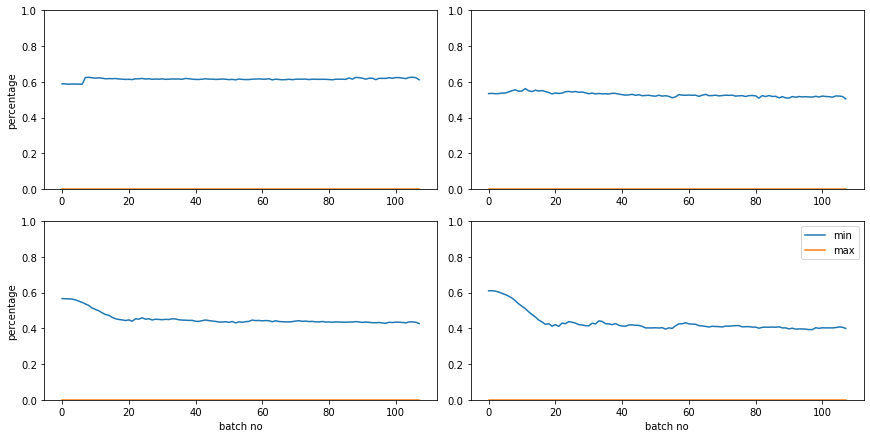

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_max_min_hist(h), label='min')
    ax.plot(get_max_min_hist(h, False), label='max')
    ax.set_ylim(0,1)
plt.tight_layout()
axes[0,0].set_title('')
for ax in axes[1]: ax.set_xlabel('batch no')
for ax in axes[:,0]: ax.set_ylabel('percentage')
plt.legend();

It's dropped from ~80% to less than 60%, and we're using more bins. Now let's go right back to our mean and stddevs

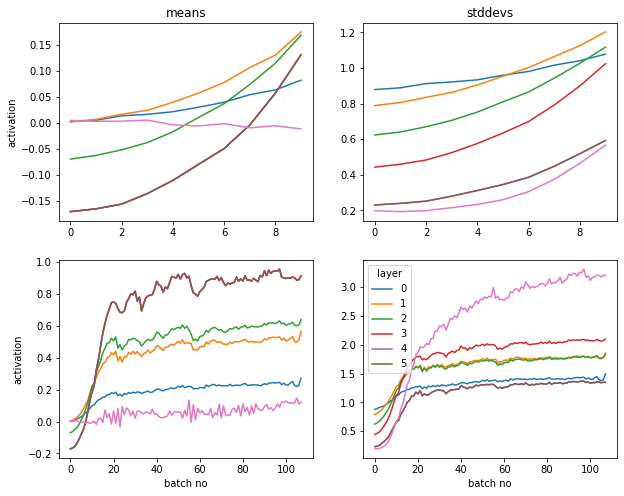

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

Ok... blowing up a bit at the start again. We could try some fine-tuning of our GReLU parameters, but let's see if we can fix it with some learning rate annealing

In [12]:
# reset model
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [13]:
sched = combine_schedules([0.5, 0.5],
                          [sched_cosine(0.1, 1),
                           sched_cosine(1, 0.2)]) 

# add annealing callbacks
cbs = [BatchTransformCB(mnist_view),
       Recorder(),
       AvgStatsCB([acc_f]),
       ParamScheduler('lr', sched)]

job = DLJob(cbs)

In [14]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.74023078125, tensor(0.7732)]
valid: [0.23250390625, tensor(0.9309)]
train: [nan, tensor(0.3432)]
valid: [nan, tensor(0.0991)]
train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]


Wow! Look how quickly the validation loss fell!

In [2]:
!python utils/export_notebook.py 12_GeneralReLU.ipynb

Notebook 12_GeneralReLU.ipynb has been converted to module ./exports/e_12_GeneralReLU.py!
